<a href="https://colab.research.google.com/github/nebulous05/influence-functions-pytorch/blob/main/influence_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### PROCEDURE ###

# Step 1: Train a model on the 10-class MNIST dataset
# Step 2: Arbitrarily select a wrongly-classified test point, z_test
# Step 3: Compute the influence I_up,loss(z, z_test) for every training point z
# Step 4: Select the 500 training points with the largest |I_up,loss(z, z_test)|
# Step 5: Compute the actual change in test loss after removing the point and
#         retraining for each of the 500 points
# Step 6: Plot -1/n (I_up,loss(z, z_test)) vs. actual change in test loss for
#         each of the 500 points

In [ ]:
# Step 2: Arbitrarily select a wrongly-classified test point, z_test

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.autograd import grad

In [2]:
# data is torch.FloatTensor; shape = (1, 28, 28)
# load train data: 60,000 samples
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

#loading test data: 10,000 samples
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5455731.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 157984.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1296625.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2704888.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
def get_item(index, dataset='train'):
    ''' returns a pair (image_tensor, label_int) '''
    if dataset == 'train':
        return train_dataset[index]
    elif dataset == 'test':
        return test_dataset[index]

def show_image(index, dataset='train'):
    ''' show an image with matplotlib '''
    if dataset == 'train':
        img = train_dataset[index][0].numpy().reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.show()
    elif dataset == 'test':
        img = test_dataset[index][0].numpy().reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.show()

In [37]:
# load train and test data samples into dataloader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# custom module for logistic regression
class LRModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(n_inputs, n_outputs)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [7]:
# instantiate the model
n_inputs = 28*28
n_outputs = 10
model = LRModel(n_inputs, n_outputs)
model.load_state_dict(torch.load('model_weights.pth'))

<ipython-input-7-ac56d928a54d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

In [20]:
loss_fn = nn.CrossEntropyLoss()

def find_misclassified_indices(model=model, test_dataset=test_dataset):
  ''' returns a list of indices of all incorrectly labeled test points '''
  model.eval()
  indices = []
  for i in range(len(test_dataset)):
    image, label = get_item(i, dataset='test')
    image = image.view(-1, 28*28)
    with torch.no_grad():
      y_pred = model(image)
      _, predicted = torch.max(y_pred.data, 1)
      if predicted != label:
        indices.append(i)
  return indices

mislabeled_indices = find_misclassified_indices()

In [ ]:
# print(random.choice(mislabeled_indices))

7620


label:  3


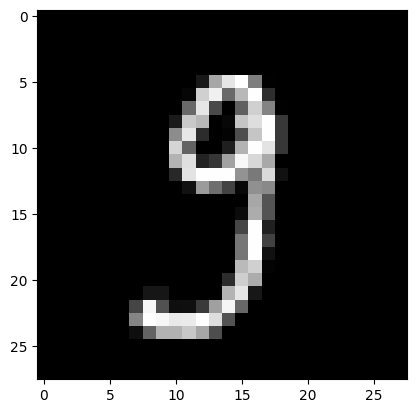

In [44]:
image_label = get_item(7620, dataset='test')
z_test = image_label[0].view(-1, 28*28)
z_test_label = torch.tensor([train_dataset[7620][1]])

print("label: ", image_label[1])
show_image(7620)

In [ ]:
# Step 3: Compute the influence I_up,loss(z, z_test) for every training point z

In [40]:
batch_indices = [1,2,3]
train_batch = [train_dataset[i] for i in batch_indices]
train_batch_inputs = torch.stack([x[0].view(-1, 28*28).squeeze() for x in train_batch])
train_batch_labels = torch.tensor([x[1] for x in train_batch])

# model.zero_grad()
# output = model(train_batch_inputs)
# loss = loss_fn(output, train_batch_labels)

# print(output.shape)
# print(train_batch_labels.shape)

torch.Size([3, 10])
torch.Size([3])


In [66]:
# get gradient of loss wrt params to kick off LiSSA
def compute_v(model, z_test, z_test_label, loss_fn):
    model.zero_grad()
    output = model(z_test)
    loss = loss_fn(output, z_test_label)

    v = grad(loss, model.parameters())
    return v

# returns list of torch tensors containing product of Hessian and v.
def hvp(y, w, v):
    # First backprop: Compute the gradient of y with respect to w
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(first_grads, v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop: Compute gradient of elementwise product with respect to w
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

# Precompute s_test using stochastic estimation, now using a mini-batch from the training data
def compute_s_test(model, z_test, v, loss_fn, scale=25, recursion_depth=5000, damping=0, batch_size=1, num_samples=10):
    model.eval()
    s_test = None

    for _ in range(num_samples):
        h_estimate = v  # Start with the gradient of z_test

        for i in range(recursion_depth):
            # Sample a random mini-batch from the training data
            batch_indices = random.sample(range(len(train_dataset)), batch_size)
            train_batch = [train_dataset[i] for i in batch_indices]
            train_batch_inputs = torch.stack([x[0].view(-1, 28*28).squeeze() for x in train_batch])
            train_batch_labels = torch.tensor([x[1] for x in train_batch])

            model.zero_grad()
            output = model(train_batch_inputs)
            loss = loss_fn(output, train_batch_labels)

            # Compute the Hessian-vector product
            hv = hvp(loss, list(model.parameters()), h_estimate)

            # Recursively update h_estimate
            h_estimate = [
                _v + (1 - damping) * _h_e - _hv / scale
                for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]

        if s_test is None:
            s_test = h_estimate
        else:
            s_test = [s + h for s, h in zip(s_test, h_estimate)]

    # Average over the number of samples
    s_test = [s / num_samples for s in s_test]

    return s_test

In [65]:
v = compute_v(model, z_test, z_test_label, loss_fn)
s_test = compute_s_test(model, z_test, v, loss_fn, recursion_depth=10, num_samples=1)

print(s_test)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<DivBackward0>), tensor([ 0.0167,  0.0057,  0.0045,  0.3037,  0.0918,  0.2346,  0.0062,  0.0256,
         0.1686, -2.1770], grad_fn=<DivBackward0>)]


In [61]:
v = compute_v(model, z_test, z_test_label, loss_fn)

h_estimate = v
damping = 0
scale = 25

print(h_estimate)


batch_indices = [1,2,3]
train_batch = [train_dataset[i] for i in batch_indices]
train_batch_inputs = torch.stack([x[0].view(-1, 28*28).squeeze() for x in train_batch])
train_batch_labels = torch.tensor([x[1] for x in train_batch])

model.zero_grad()
output = model(train_batch_inputs)
loss = loss_fn(output, train_batch_labels)

# Compute the Hessian-vector product
hv = hvp(loss, list(model.parameters()), h_estimate)


# # Recursively update h_estimate
h_estimate = [
    _v + (1 - damping) * _h_e - _hv / scale
    for _v, _h_e, _hv in zip(v, h_estimate, hv)
]

print(h_estimate)

# print(list(model.parameters()))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]]), tensor([ 0.0016,  0.0007,  0.0005,  0.0287,  0.0084,  0.0224,  0.0006,  0.0027,
         0.0164, -0.2074]))
[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]], grad_fn=<SubBackward0>), tensor([ 0.0031,  0.0014,  0.0010,  0.0572,  0.0166,  0.0447,  0.0013,  0.0054,
         0.0328, -0.4143], grad_fn=<SubBackward0>)]
